In [1]:
import os
import time
import warnings
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio
import seaborn as sns
import spectral
import pywt
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, classification_report,
                             cohen_kappa_score, confusion_matrix)
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.layers import (Layer, DepthwiseConv2D, Conv3D, Conv2D, Conv1D, MaxPooling1D, Dense, Dropout,
                          Flatten, Input, Reshape, MaxPooling2D, SeparableConv2D, Softmax, MaxPooling3D, 
                          MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, GlobalAveragePooling3D, 
                          concatenate, GRU, Reshape, LayerNormalization)
from keras_cv_attention_models import attention_layers
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from keras.losses import categorical_crossentropy
from keras.models import Model, Sequential
# from keras.utils import np_utils
from tensorflow.keras.layers import (Activation, Lambda, multiply)
from tensorflow.keras.optimizers import Adam
from keras.optimizers import Adam
from tensorflow.keras.optimizers import legacy
from operator import truediv
from vit_keras import utils, vit
from keras.utils import to_categorical

2025-08-02 12:57:11.295221: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-02 12:57:11.960810: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-02 12:57:11.960979: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-02 12:57:12.067982: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-02 12:57:12.287183: I tensorflow/core/platform/cpu_feature_guar

## Preparing Data links

In [ ]:
## Loading Datasets
def LoadHSIData(method):
    data_path = os.path.abspath("../HSI/")
    if method == 'IP':
        HSI = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        GT = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
        Num_Classes = 16
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn',
                        'Grass-pasture', 'Grass-trees', 'Grass-mowed',
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings',
                        'Stone-Steel']
    elif method == 'HC':
        HSI = sio.loadmat(os.path.join(data_path, 'WHU_Hi_HanChuan.mat'))['WHU_Hi_HanChuan']
        GT = sio.loadmat(os.path.join(data_path, 'WHU_Hi_HanChuan_gt'))['WHU_Hi_HanChuan_gt']
        Num_Classes = 16
        target_names = ['Strawberry', 'Cowpea', 'Soybean', 'Sorghum',
                        'Water spinach', 'Watermelon', 'Greens', 'Trees', 'Grass',
                        'Red roof', 'Gray roof', 'Plastic', 'Bare soil', 'Road',
                        'Bright object', 'Water']
    return HSI, GT, Num_Classes, target_names

## Prediction Module

In [ ]:
## Prediction Model
def PreModel(Actual, model):
  prediction = model.predict(Actual)
  argmax_prediction = np.argmax(prediction, axis=1) + 1
  # non_zero_classes = np.unique(argmax_prediction)
  # if 0 in non_zero_classes:
  #   non_zero_classes = non_zero_classes[non_zero_classes != 0]
  # Pre = argmax_prediction[np.isin(argmax_prediction, non_zero_classes)]
  return argmax_prediction

## Plot Ground Truths for Complete Dataset as Trivial Cases
def GT_Plot(RDHSI, GT, model, WS, k, batch_size=256):
  height, width = GT.shape
  outputs = np.zeros((height, width))
  count = 0
  for i in range(0, len(RDHSI), batch_size):
    batch_RDHSI = RDHSI[i:i+batch_size]
    batch_pred = model.predict(batch_RDHSI)
    """Because patches are generated for non-zero (foreground) samples only, 
        one should add +1 in the following code to ensure the first class is not skipped."""
    batch_pred_argmax = np.argmax(batch_pred, axis=1) + 1
    batch_pred_argmax = batch_pred_argmax.reshape(-1)
    for j in range(len(batch_pred_argmax)):
      if count >= height * width:
        break
      target = int(GT[count // width, count % width])
      if target != 0:
        outputs[count // width, count % width] = batch_pred_argmax[j] + 1
      count += 1
  return outputs

## Convert GT and Predicted HSI GTs into one-Hot encoding
def Convert(GT, flattened):
  height, width = GT.shape
  unique_values = np.unique(flattened)
  unique_values = np.delete(unique_values, np.where(unique_values == 0))
  AB = len(unique_values)
  if len(unique_values) > AB:
    unique_values = unique_values[:AB]
  GTA = np.zeros((height * width, len(unique_values)), dtype=int)
  T_labels_flat = flattened.flatten()
  for idx, cls in enumerate(unique_values):
    GTA[:, idx] = (T_labels_flat == cls)
  return GTA

## Classification Reports

In [4]:
## Computing the Accuracies and Confusion Matrix for Disjoint Samples
def ClassificationReports(TeC, HSID, Te_Pre, target_names):
  classification = classification_report(np.argmax(TeC, axis=1)+1, Te_Pre, target_names = target_names)
  oa = accuracy_score(np.argmax(TeC, axis=1)+1, Te_Pre)
  oa = round(oa, 4)
  confusion = confusion_matrix(np.argmax(TeC, axis=1)+1, Te_Pre)
  list_diag = np.diag(confusion)
  list_raw_sum = np.sum(confusion, axis=1)
  each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
  aa = np.mean(each_acc)
  aa = round(aa, 4)
  kappa = cohen_kappa_score(np.argmax(TeC, axis=1)+1, Te_Pre)
  kappa = round(kappa, 4)
  return classification, confusion, oa*100, each_acc*100, aa*100, kappa*100

## Computing the Accuracies and Confusion Matrix for Complete HSI
def ClassificationReports_HSI(TeC, HSID, Te_Pre, target_names):
  T_classification = classification_report(np.argmax(TeC, axis=1), np.argmax(Te_Pre, axis=1), target_names = target_names)
  T_oa = accuracy_score(np.argmax(TeC, axis=1), np.argmax(Te_Pre, axis=1))
  oa = round(T_oa, 4)
  T_confusion = confusion_matrix(np.argmax(TeC, axis=1), np.argmax(Te_Pre, axis=1))
  list_diag = np.diag(T_confusion)
  list_raw_sum = np.sum(T_confusion, axis=1)
  T_each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
  T_aa = np.mean(T_each_acc)
  T_aa = round(T_aa, 4)
  T_kappa = cohen_kappa_score(np.argmax(TeC, axis=1), np.argmax(Te_Pre, axis=1))
  T_kappa = round(T_kappa, 4)
  return T_classification, T_confusion, T_oa*100, T_each_acc*100, T_aa*100, T_kappa*100

## Saving Classification Results

In [5]:
## Writing Results in CSV files
def CSVResults(file_name, Va_classification, Va_Confusion, Tr_Time, Va_Time,
               Te_Time, T_Time, Va_Kappa, Va_OA, Va_AA, Va_Per_Class,
               Te_classification, Te_Confusion, Te_Kappa, Te_OA, Te_AA, Te_Per_Class,
               T_classification, T_Confusion, T_Kappa, T_OA, T_AA, T_Per_Class, trainable_parameters):
    Va_classification = str(Va_classification)
    Va_Confusion = str(Va_Confusion)
    Te_classification = str(Te_classification)
    Te_Confusion = str(Te_Confusion)
    T_classification = str(T_classification)
    T_Confusion = str(T_Confusion)
    with open(file_name, 'w') as CSV_file:
      CSV_file.write('{} Tr_Time'.format(Tr_Time))
      CSV_file.write('\n')
      CSV_file.write('{} Va_Time'.format(Va_Time))
      CSV_file.write('\n')
      CSV_file.write('{} Te_Time'.format(Te_Time))
      CSV_file.write('\n')
      CSV_file.write('{} HSI_Time'.format(T_Time))
      CSV_file.write('\n')
      CSV_file.write('{} Param'.format(trainable_parameters))
      CSV_file.write('\n')
      CSV_file.write('{} Va Kappa (%)'.format(Va_Kappa))
      CSV_file.write('\n')
      CSV_file.write('{} Va Overall (%)'.format(Va_OA))
      CSV_file.write('\n')
      CSV_file.write('{} VA Average (%)'.format(Va_AA))
      CSV_file.write('\n')
      CSV_file.write('{} Te Kappa (%)'.format(Te_Kappa))
      CSV_file.write('\n')
      CSV_file.write('{} Te Overall (%)'.format(Te_OA))
      CSV_file.write('\n')
      CSV_file.write('{} Te Average (%)'.format(Te_AA))
      CSV_file.write('\n')
      CSV_file.write('{} HSI Kappa (%)'.format(T_Kappa))
      CSV_file.write('\n')
      CSV_file.write('{} HSI Overall (%)'.format(T_OA))
      CSV_file.write('\n')
      CSV_file.write('{} HSI Average (%)'.format(T_AA))
      CSV_file.write('\n')
      CSV_file.write('{} VA Per Class'.format(Va_Per_Class))
      CSV_file.write('\n')
      CSV_file.write('{} Te Per Class'.format(Te_Per_Class))
      CSV_file.write('\n')
      CSV_file.write('{} HSI Per Class'.format(T_Per_Class))
      CSV_file.write('\n')
      CSV_file.write('{} VA Classification'.format(Va_classification))
      CSV_file.write('\n')
      CSV_file.write('{} VA Confussion'.format(Va_Confusion))
      CSV_file.write('\n')
      CSV_file.write('{} Te Classification'.format(Te_classification))
      CSV_file.write('\n')
      CSV_file.write('{} Te Confussion'.format(Te_Confusion))
      CSV_file.write('\n')
      CSV_file.write('{} HSI Classification'.format(T_classification))
      CSV_file.write('\n')
      CSV_file.write('{} HSI Confussion'.format(T_Confusion))
      CSV_file.write('\n')
    return CSV_file

## Dimensional Reduction

In [6]:
## Dimensional Reduction
def DLMethod(HSI, NC = 75):
  RHSI = np.reshape(HSI, (-1, HSI.shape[2]))
  pca = PCA(n_components = NC, whiten = True)
  RHSI = pca.fit_transform(RHSI)
  RHSI = np.reshape(RHSI, (HSI.shape[0], HSI.shape[1], NC))
  return RHSI

## Initializing Parameters

In [7]:
## Global Parameters for Loop
HSID = "HC" ## IP, PU, HH, HC, 
WS = 8
teRatio = 0.50
vrRatio = 0.50
k = 15
adam = tf.keras.optimizers.legacy.Adam(lr = 0.001, decay = 1e-06)
epochs = 10
batch_size = 56

/home/ahmad/miniconda3/envs/hsi/lib/python3.10/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


## 3D Patches

In [8]:
## Creat Patches for 3D (Spatial-Spectral) Models
def ImageCubes(HSI, GT, WS=WS, removeZeroLabels=True):
    num_rows, num_cols, num_bands = HSI.shape
    margin = int(WS / 2)
    padded_data = np.pad(HSI, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    image_cubes = np.zeros((num_rows * num_cols, WS, WS, num_bands))
    patchesLabels = np.zeros((num_rows * num_cols))
    patchIndex = 0
    for r in range(margin, num_rows + margin):
        for c in range(margin, num_cols + margin):
            cube = padded_data[r - margin: r + margin, c - margin: c + margin, :]
            image_cubes[patchIndex, :, :, :] = cube
            patchesLabels[patchIndex] = GT[r-margin, c-margin]
            patchIndex = patchIndex + 1
    return image_cubes, patchesLabels

## Loading and Creating Patches for HSI

In [9]:
HSI, GT, Num_Classes, target_names = LoadHSIData(HSID)
start = time.time()
RDHSI = DLMethod(HSI, NC = k)
end = time.time()
DL_Time = end - start
CRDHSI, CGT = ImageCubes(RDHSI, GT, WS = WS)

## Disjoint Train/Val/Test Sets

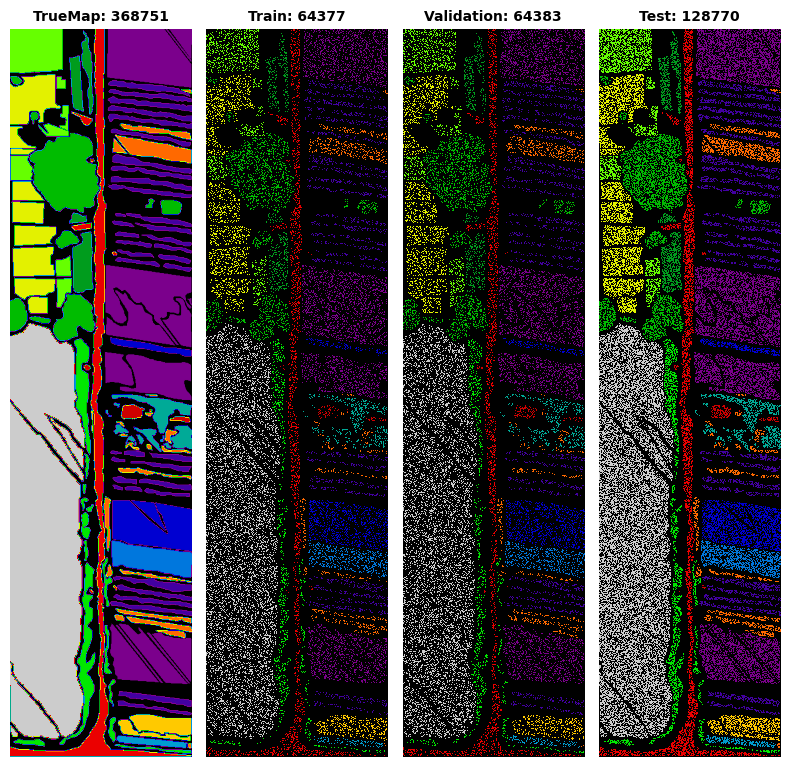

In [ ]:
np.random.seed(42)
num_rows, num_cols = GT.shape
flattened = GT.flatten()
unique_values, value_counts = np.unique(flattened, return_counts=True)
nonzero_indices = np.where(unique_values != 0)[0]
unique_values = unique_values[nonzero_indices]
Samples = pd.DataFrame(columns=['Training', 'Validation', 'Test'])
TrInd = []
VaInd = []
TeInd = []
for value in unique_values:
    class_indices = np.where(flattened == value)[0]
    train_indices, test_indices = train_test_split(class_indices, test_size=teRatio)
    train_indices, val_indices = train_test_split(train_indices, test_size=vrRatio)
    Samples.loc[value] = [len(train_indices), len(val_indices), len(test_indices)]
    TrInd.extend(train_indices)
    VaInd.extend(val_indices)
    TeInd.extend(test_indices)

file_name = f"{HSID}_{teRatio}_{vrRatio}_{k}_{WS}_Samples.csv"
Samples.to_csv(file_name, index_label='Class')
# train_matrix = np.zeros_like(GT)
# val_matrix = np.zeros_like(GT)
# test_matrix = np.zeros_like(GT)
# train_matrix.flat[TrInd] = 1
# val_matrix.flat[VaInd] = 1
# test_matrix.flat[TeInd] = 1
# TRC = CGT[TrInd]
# TRC_labels = Tranform_Labels(train_matrix, TrInd, TRC)
# VAC = CGT[VaInd]
# VAC_labels = Tranform_Labels(val_matrix, VaInd, VAC)
# TEC = CGT[TeInd]
# TEC_labels = Tranform_Labels(test_matrix, TeInd, TEC)
# ## Plot Ground Truths
# cmap = 'nipy_spectral'
# plt.figure(figsize=(8, 8))
# plt.subplot(1, 4, 1)
# plt.imshow(GT, cmap=cmap)
# plt.title(f'TrueMap: {num_rows*num_cols}', fontsize=10, fontweight='bold')
# plt.axis('off')
# plt.subplot(1, 4, 2)
# plt.imshow(TRC_labels, cmap=cmap, interpolation='nearest')
# plt.title(f'Train: {len(TrInd)}', fontsize=10, fontweight='bold')
# plt.axis('off')
# plt.subplot(1, 4, 3)
# plt.imshow(VAC_labels, cmap=cmap, interpolation='nearest')
# plt.title(f'Validation: {len(VaInd)}', fontsize=10, fontweight='bold')
# plt.axis('off')
# plt.subplot(1, 4, 4)
# plt.imshow(TEC_labels, cmap=cmap, interpolation='nearest')
# plt.title(f'Test: {len(TeInd)}', fontsize=10, fontweight='bold')
# plt.axis('off')
# plt.tight_layout()
# ## Save the plot
# file_name = f"{HSID}_{teRatio}_{vrRatio}_{k}_{WS}_Train_Test_Mask.png"
# plt.savefig(file_name, dpi=500, format='png', bbox_inches='tight', pad_inches=0)
## Select Train/Validation/Test Samples
Tr = CRDHSI[TrInd]
Va = CRDHSI[VaInd]
Te = CRDHSI[TeInd]
TrC = to_categorical(CGT[TrInd] -1)
VaC = to_categorical(CGT[VaInd] -1)
TeC = to_categorical(CGT[TeInd] -1)

## Policy Attention based Vision Mamba

In [ ]:
## Pilicy Attention 
class LPAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim, sparsity_level=0.1, window_size=(WS, WS),**kwargs):
        super(LPAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.sparsity_level = sparsity_level
        self.window_size = window_size
        self.query_dense = Dense(num_heads * key_dim)
        self.key_dense = Dense(num_heads * key_dim)
        self.value_dense = Dense(num_heads * key_dim)
        self.output_dense = Dense(key_dim)
        self.softmax = Softmax(axis=-1)

    def compute_attention(self, spatial_patch, spectral_patch1, spectral_patch2):
      query = self.query_dense(spatial_patch)
      key = self.key_dense(spectral_patch1)
      value = self.value_dense(spectral_patch2)
      batch_size = tf.shape(spatial_patch)[0]
      WS, WS, Embeddings = tf.shape(spatial_patch)[1], tf.shape(spatial_patch)[2], tf.shape(spatial_patch)[-1]
      query = tf.reshape(query, (batch_size, WS*WS, self.num_heads, self.key_dim))
      key = tf.reshape(key, (batch_size, WS*WS, self.num_heads, self.key_dim))
      value = tf.reshape(value, (batch_size, WS*WS, self.num_heads, self.key_dim))
      attention_scores = tf.einsum('bhqd,bhkd->bhqk', query, key)
      attention_scores /= tf.math.sqrt(tf.cast(self.key_dim, tf.float32))
      if self.sparsity_level < 1.0:
        k = tf.cast(self.sparsity_level * tf.cast(tf.shape(attention_scores)[-1], tf.float32), tf.int32)
        top_k_values, _ = tf.nn.top_k(attention_scores, k=k)
        threshold = tf.reduce_min(top_k_values, axis=-1, keepdims=True)
        attention_scores = tf.where(attention_scores >= threshold, attention_scores, tf.fill(tf.shape(attention_scores), float('-inf')))
      attention_weights = self.softmax(attention_scores)
      attention_output = tf.einsum('bhqk,bhvd->bhqd', attention_weights, value)
      attention_output = tf.reshape(attention_output, (batch_size, WS, WS, self.num_heads * self.key_dim))
      output = self.output_dense(attention_output)
      return output
## Spatial SpectrL Token Generation 
class SSPASSToken(tf.keras.layers.Layer):
    def __init__(self, out_channels, kernel_size=3, **kwargs):
        super(SSPASSToken, self).__init__(**kwargs)
        self.spatial_tokens = Conv2D(out_channels, kernel_size=kernel_size, padding='same')
        self.spectral_tokens = Conv2D(out_channels, kernel_size=kernel_size, padding='same')
    def call(self, x):
        spatial_tokens = self.spatial_tokens(x)
        spectral_tokens = self.spectral_tokens(x)
        return spatial_tokens, spectral_tokens
## Token Enhacnement
class SSPASSFE(tf.keras.layers.Layer):
    def __init__(self, out_channels, **kwargs):
        super(SSPASSFE, self).__init__(**kwargs)
        self.spatial_gate = Sequential([
            Dense(out_channels),
            tf.keras.layers.Activation('swish'),
        ])
        self.spectral_gate = Sequential([
            Dense(out_channels),
            tf.keras.layers.Activation('swish'),
        ])
    def call(self, spatial_tokens, spectral_tokens, center_tokens):
        center_tokens = tf.expand_dims(tf.expand_dims(center_tokens, 1), 1)
        spatial_enhanced = spatial_tokens * self.spatial_gate(center_tokens)
        spectral_enhanced = spectral_tokens * self.spectral_gate(center_tokens)
        return spatial_enhanced, spectral_enhanced
## Selective State Space Model 
class SSPASSSSM(tf.keras.layers.Layer):
    def __init__(self, state_dim, **kwargs):
        super(SSPASSSSM, self).__init__(**kwargs)
        self.state_dim = state_dim
        self.state_transition = Dense(state_dim)
        self.state_update = Dense(state_dim)
    def call(self, x):
        B, H, W, C = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2], tf.shape(x)[3]
        x = tf.reshape(x, (B, H * W, C))
        x_transformed = self.state_update(x)
        x_transformed = tf.reshape(x_transformed, (B, H * W, self.state_dim))
        state = tf.zeros([B, H * W, self.state_dim])
        def step_fn(a, x):
            transitioned_state = self.state_transition(a)
            return transitioned_state + x
        state_seq = tf.scan(step_fn, x_transformed, initializer=state)
        return state_seq[:, -1, :]
## PolicyMamba
class PolicyMamba(tf.keras.Model):
    def __init__(self, out_channels, num_heads, state_dim, num_classes, dropout=0.1, **kwargs):
        super(PolicyMamba, self).__init__(**kwargs)
        self.token_generation = SSPASSToken(out_channels)
        self.feature_enhancement = SSPASSFE(out_channels)
        self.LP_Attention = LPAttention(num_heads, out_channels)
        self.state_space_model = SSPASSSSM(state_dim)
        self.dense = Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.dropout = Dropout(0.4)
        self.classifier = Dense(num_classes, activation='softmax')
    def call(self, x):
        spatial_tokens, spectral_tokens = self.token_generation(x)
        center_tokens = tf.reduce_mean(spatial_tokens, axis=[1, 2])
        spatial_enhanced, spectral_enhanced = self.feature_enhancement(spatial_tokens, spectral_tokens, center_tokens)
        attention_output = self.LP_Attention(spatial_enhanced, spectral_enhanced, spectral_enhanced)
        state_output = self.state_space_model(attention_output)
        x = tf.keras.layers.GlobalMaxPooling1D()(state_output)
        x = self.dense(x)
        x = self.dropout(x)
        return self.classifier(x)
def PMamba(Tr, batch_size, Num_Classes):
    model = PolicyMamba(out_channels=64, num_heads=8, state_dim=128, num_classes=Num_Classes, dropout=0.1)
    sample_input = Tr[:batch_size]
    _ = model(sample_input)
    return model

## Prepare Training Models

In [ ]:
def train_and_evaluate_model(model_name, Tr, TrC, Va, VaC, Te, TeC, adam,
                             CRDHSI, HSID, teRatio, k, WS, RDHSI,
                             GT,Num_Classes,batch_size,epochs, val_matrix,
                             VaInd, test_matrix, TeInd, flattened):
    print(f"Model name: {model_name}")
    ## Initialize model
    # if model_name in [WaveMamba, SSMamba, MHSAMamba, MorpMamba, GraphMamba, PMamba]:
    #     Tr = Tr.reshape(-1, WS, WS, k)
    #     Va = Va.reshape(-1, WS, WS, k)
    #     Te = Te.reshape(-1, WS, WS, k)
    #     model = model_name(Tr, batch_size, Num_Classes)
    # elif model_name == WaveFormer:
    #     Tr = Tr.reshape(-1, WS, WS, k)
    #     Va = Va.reshape(-1, WS, WS, k)
    #     Te = Te.reshape(-1, WS, WS, k)
    #     Tr = wavelet_transform_image(Tr)
    #     Va = wavelet_transform_image(Va)
    #     Te = wavelet_transform_image(Te)
    #     model = model_name(WS, k, Num_Classes)
    # elif model_name in [CNN3D, IN3D, HCNN, HIN]:
    #     CRDHSI = CRDHSI.reshape(-1, WS, WS, k, 1)
    #     model = model_name(WS, k, Num_Classes)
    # else:
    #     model = model_name(WS, k, Num_Classes)
    model = model_name(WS, k, Num_Classes)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    start = time.time()
    history = model.fit(x=Tr, y=TrC, batch_size=batch_size, epochs=epochs, validation_data=(Va, VaC))
    end = time.time()
    Tr_Time = end - start
    trainable_parameters = model.count_params()
    ## Validation
    start = time.time()
    Va_Pre = PreModel(Va, model)
    end = time.time()
    Va_Time = end - start
    ## Test
    start = time.time()
    Te_Pre = PreModel(Te, model)
    end = time.time()
    Te_Time = end - start
    ## Complete HSI
    start = time.time()
    T_labels = GT_Plot(CRDHSI, GT, model, WS, k)
    T_labels = T_labels.astype(int)
    end = time.time()
    T_Time = end - start
    ## Convert outputs to one-hot encoding
    GTA = Convert(GT, flattened)
    GTA = GTA.astype(int)
    T_Predicted = Convert(GT, T_labels)
    T_Predicted = T_Predicted.astype(int)
    ## Classification Report for Validation Model
    Va_classification,Va_Confusion,Va_OA,Va_Per_Class,Va_AA,Va_Kappa = ClassificationReports(VaC, HSID, Va_Pre, target_names)
    Va_Kappa = round(Va_Kappa, 4)
    ## Classification Report for Test Model
    Te_classification,Te_Confusion,Te_OA,Te_Per_Class,Te_AA,Te_Kappa = ClassificationReports(TeC, HSID, Te_Pre, target_names)
    Te_Kappa = round(Te_Kappa, 4)
    ## Classification Report for Complete HSI Model
    T_classification,T_Confusion,T_OA,T_Per_Class,T_AA,T_Kappa = ClassificationReports_HSI(GTA, HSID, T_Predicted, target_names)
    T_Kappa = round(T_Kappa, 4)
    ## Writing Results in CSV File
    file_name = f"{HSID}_{teRatio}_{k}_{WS}_Classification_Report_{model_name.__name__}.csv"
    CSV_file = CSVResults(file_name, Va_classification, Va_Confusion, Tr_Time, Va_Time,
                        Te_Time, T_Time, Va_Kappa, Va_OA, Va_AA, Va_Per_Class,
                        Te_classification, Te_Confusion, Te_Kappa, Te_OA, Te_AA, Te_Per_Class,
                        T_classification, T_Confusion, T_Kappa, T_OA, T_AA, T_Per_Class, trainable_parameters)

    ## Plot Ground Truths
    cmap = 'nipy_spectral'
    plt.figure(figsize=(8, 8))
    # plt.subplot(1, 3, 1)
    # plt.imshow(Va_labels, cmap=cmap, interpolation='nearest')
    # plt.title(f'Dis_Validation: {Va_Kappa}%', fontsize=10, fontweight='bold')
    # plt.axis('off')
    # plt.subplot(1, 3, 2)
    # plt.imshow(Te_labels, cmap=cmap, interpolation='nearest')
    # plt.title(f'Dis_Test: {Te_Kappa}%', fontsize=10, fontweight='bold')
    # plt.axis('off')
    plt.subplot(1, 1, 1)
    plt.imshow(T_labels, cmap=cmap, interpolation='nearest')
    plt.title(f'Complete HSI: {T_Kappa}%', fontsize=10, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    file_name = f"{HSID}_{teRatio}_{k}_{WS}_Predicted_GTs_{model_name.__name__}.png"
    plt.savefig(file_name, dpi=600, format='png', bbox_inches='tight', pad_inches=0)
    return history

## Train & Test the Model

Model name: <function PMamba at 0x78269fc4df30>


2025-08-02 12:57:37.311698: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-02 12:57:37.833805: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-02 12:57:37.833920: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-02 12:57:37.842058: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-02 12:57:37.842220: I external/local_xla/xla/stream_executor

Model: "policy_mamba"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sspass_token (SSPASSToken)  multiple                  17408     
                                                                 
 sspassfe (SSPASSFE)         multiple                  8320      
                                                                 
 lp_attention (LPAttention)  multiple                  0         
                                                                 
 sspassssm (SSPASSSSM)       multiple                  24832     
                                                                 
 dense_8 (Dense)             multiple                  16512     
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dense_9 (Dense)             multiple                 

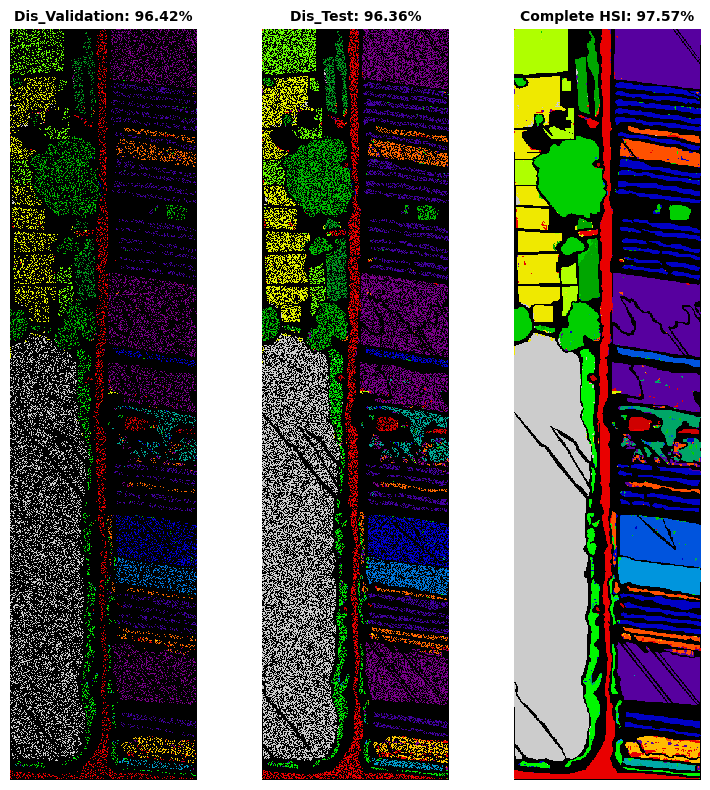

In [33]:
## Define a list of model names
# model_names = [CNN2D, CNN3D, HCNN, IN2D, IN3D, HIN, X2D, XXNet, AGCN, SCSNet, PyFormer, HFormer, SSFormer, WaveFormer, DFormer, 
#                SSMamba, MHSAMamba, WaveMamba, MorpMamba, GraphMamba, PMamba]
model_names = [PMamba]
# Loop over the model names
history_list = []
for model_name in model_names:
    history = train_and_evaluate_model(model_name, Tr, TrC, Va, VaC, Te, TeC,
                                       adam, CRDHSI, HSID, teRatio, k, WS,
                                       RDHSI, GT, Num_Classes, batch_size,
                                       epochs, val_matrix, VaInd,
                                       test_matrix, TeInd, flattened)
    history_list.append(history)

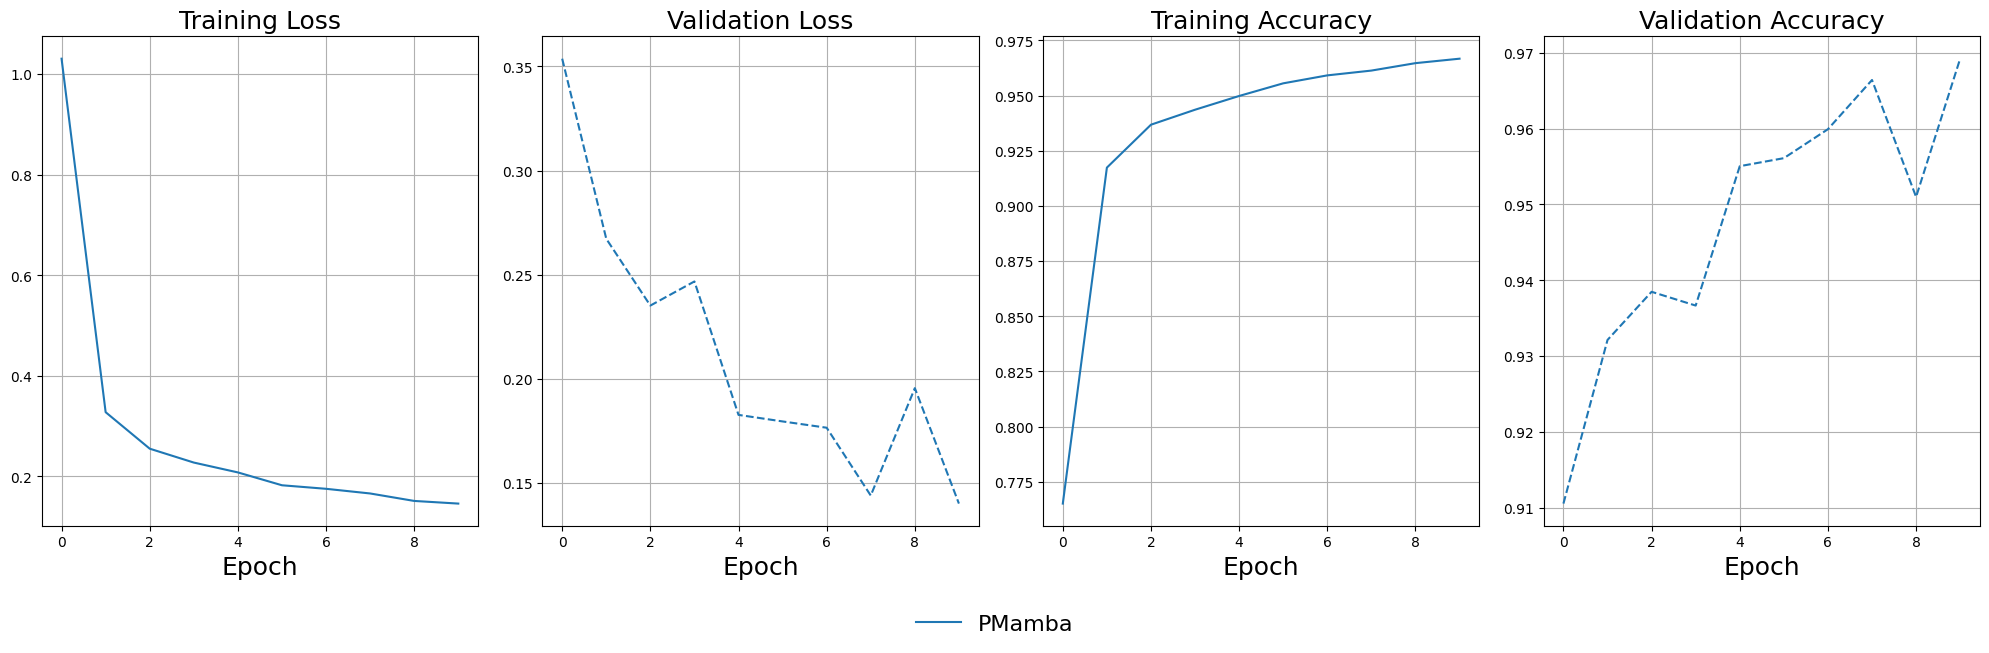